In [2]:
import pandas as pd
import os

# Optional: Clean warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

# === Step 1: Explicitly list Excel files from 2017 to 2023 ===
years = list(range(2017, 2024))
file_names = [f"{year}.xlsx" for year in years]
all_data = []

for file in file_names:
    if os.path.exists(file):
        print(f"Reading: {file}")
        df = pd.read_excel(file)

        # Rename by position — robust to naming variation
        df.columns.values[0] = 'date'      # 日期
        df.columns.values[1] = 'maturity'  # 标准期限说明
        df.columns.values[3] = 'yield'     # 收益率(%)

        df = df[['date', 'maturity', 'yield']]
        df['source_file'] = file  # Optional: traceability
        all_data.append(df)
    else:
        print(f"Missing file: {file}")

# === Step 2: Combine and clean data ===
data = pd.concat(all_data)
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data = data.dropna(subset=['date', 'yield'])
data['maturity'] = data['maturity'].str.strip()

# === Step 3: Filter for selected maturities ===
selected_maturities = ['3m', '1y', '5y', '10y']
data = data[data['maturity'].isin(selected_maturities)]

# === Step 4: Pivot to wide format ===
yield_ts = data.pivot_table(index='date', columns='maturity', values='yield', dropna=False)
yield_ts = yield_ts.sort_index()

# === Step 5: Export ===
yield_ts.to_csv('china_yield_timeseries_3m_1y_5y_10y.csv')
print("Combined yield time series saved as 'china_yield_timeseries_3m_1y_5y_10y.csv'.")

print("Year coverage:", yield_ts.index.min(), "→", yield_ts.index.max())


Missing file: 2017.xlsx
Reading: 2018.xlsx
Reading: 2019.xlsx
Reading: 2020.xlsx
Reading: 2021.xlsx
Reading: 2022.xlsx
Reading: 2023.xlsx
Combined yield time series saved as 'china_yield_timeseries_3m_1y_5y_10y.csv'.
Year coverage: 2018-01-02 00:00:00 → 2023-12-31 00:00:00


In [6]:

import pandas as pd

file_path = "china_yield_timeseries_3m_1y_5y_10y.csv"
df = pd.read_csv(file_path, parse_dates=["date"], index_col="date")

# Compute simple yield differences (Δyield)
daily_yield_changes = df.diff().dropna()

daily_yield_changes.to_csv("daily_yield_changes_3m_1y_5y_10y.csv")


In [7]:
pip install arch


Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 17.5 MB/s eta 0:00:000:00:01
Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
from arch import arch_model
import matplotlib.pyplot as plt

# Load your ΔYield data
df = pd.read_csv("daily_yield_changes_3m_1y_5y_10y.csv", index_col="date", parse_dates=True)

# Loop through each maturity and fit GARCH(1,1)
garch_results = {}

for col in df.columns:
    print(f"\n Fitting GARCH(1,1) for: {col}")
    
    # Drop missing values
    series = df[col].dropna()
    
    # Fit GARCH(1,1) with Student's t-distribution (like the thesis paper)
    model = arch_model(series, vol='GARCH', p=1, q=1, dist='t')
    result = model.fit(disp='off')
    
    # Store result
    garch_results[col] = result

    # Print summary
    print(result.summary())



 Fitting GARCH(1,1) for: 10y
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                          10y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                3747.12
Distribution:      Standardized Student's t   AIC:                          -7484.25
Method:                  Maximum Likelihood   BIC:                          -7457.68
                                              No. Observations:                 1500
Date:                      Thu, Apr 17 2025   Df Residuals:                     1499
Time:                              14:15:17   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------------------------------

/home/3a1b970b-0a9f-430f-ab6d-5c5f2e3979db/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004777. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/3a1b970b-0a9f-430f-ab6d-5c5f2e3979db/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008772. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/hom

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                           3m   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                2794.19
Distribution:      Standardized Student's t   AIC:                          -5578.37
Method:                  Maximum Likelihood   BIC:                          -5551.81
                                              No. Observations:                 1500
Date:                      Thu, Apr 17 2025   Df Residuals:                     1499
Time:                              14:15:17   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

/home/3a1b970b-0a9f-430f-ab6d-5c5f2e3979db/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007094. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [10]:
import pandas as pd
from arch import arch_model

# Load your ΔYield data
df = pd.read_csv("daily_yield_changes_3m_1y_5y_10y.csv", index_col="date", parse_dates=True)

maturities = ['3m', '1y', '5y', '10y']
distributions = ['normal', 't', 'ged']

# Store all results
records = []

for maturity in maturities:
    series = df[maturity].dropna()
    
    for dist in distributions:
        model = arch_model(series, vol='GARCH', p=1, q=1, dist=dist)
        res = model.fit(disp='off')

        alpha = res.params.get('alpha[1]', None)
        beta = res.params.get('beta[1]', None)
        shape_param = res.params.get('nu', res.params.get('lambda', None))  # nu for t, lambda for GED

        records.append({
            'Maturity': maturity,
            'Distribution': dist.upper(),
            'LogLik': res.loglikelihood,
            'AIC': res.aic,
            'BIC': res.bic,
            'Alpha (α)': alpha,
            'Beta (β)': beta,
            'Tail Param (ν or κ)': shape_param
        })

# Create DataFrame for comparison
results_table = pd.DataFrame.from_records(records)
results_table = results_table.sort_values(['Maturity', 'Distribution'])

# Display the final result
print("📊 GARCH(1,1) Fit Comparison for All Maturities:\n")
display(results_table)


/home/3a1b970b-0a9f-430f-ab6d-5c5f2e3979db/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001928. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/3a1b970b-0a9f-430f-ab6d-5c5f2e3979db/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001928. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/3a

📊 GARCH(1,1) Fit Comparison for All Maturities:



/home/3a1b970b-0a9f-430f-ab6d-5c5f2e3979db/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004777. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/3a1b970b-0a9f-430f-ab6d-5c5f2e3979db/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004777. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/hom

,Maturity,Distribution,LogLik,AIC,BIC,Alpha (α),Beta (β),Tail Param (ν or κ)
11,10y,GED,3727.790578,-7445.581157,-7419.015055,0.100000,0.800000,1.500000
9,10y,NORMAL,3676.580506,-7345.161012,-7323.908130,0.100008,0.799994,NaN
10,10y,T,3747.123032,-7484.246064,-7457.679962,0.100001,0.799999,5.284543
5,1y,GED,3342.234984,-6674.469969,-6647.903867,0.100000,0.800000,1.500000
3,1y,NORMAL,3191.895834,-6375.791668,-6354.538786,0.100000,0.800000,NaN
4,1y,T,3423.284161,-6836.568322,-6810.002220,0.100000,0.799999,4.303426
2,3m,GED,2753.084460,-5496.168920,-5469.602818,0.099730,0.797771,1.500094
0,3m,NORMAL,2640.212457,-5272.424913,-5251.172032,0.132969,0.766129,NaN
1,3m,T,2794.186603,-5578.373207,-5551.807105,0.100000,0.799999,5.068075
8,5y,GED,3463.988367,-6917.976733,-6891.410631,0.050000,0.929998,1.499999


In [11]:
import pandas as pd
from arch import arch_model
import matplotlib.pyplot as plt

# Load your ΔYield data
df = pd.read_csv("daily_yield_changes_3m_1y_5y_10y.csv", index_col="date", parse_dates=True)

# Select 5-year yield change series
series = df["5y"].dropna()

print("Fitting GARCH(1,1) with GED for 5-Year Yield...\n")

# Fit GARCH(1,1) with GED distribution
model = arch_model(series, vol='GARCH', p=1, q=1, dist='ged')
result = model.fit(disp='off')

# Print full model summary
print(result.summary())


Fitting GARCH(1,1) with GED for 5-Year Yield...

                           Constant Mean - GARCH Model Results                            
Dep. Variable:                                 5y   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                  GARCH   Log-Likelihood:                3463.99
Distribution:      Generalized Error Distribution   AIC:                          -6917.98
Method:                        Maximum Likelihood   BIC:                          -6891.41
                                                    No. Observations:                 1500
Date:                            Thu, Apr 17 2025   Df Residuals:                     1499
Time:                                    14:29:19   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>

/home/3a1b970b-0a9f-430f-ab6d-5c5f2e3979db/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007094. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


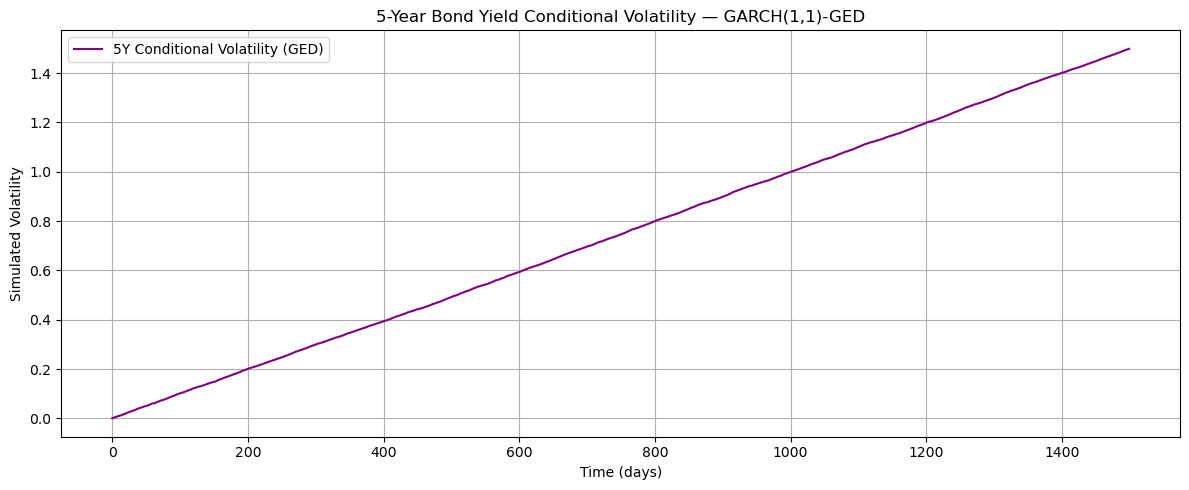


 GARCH(1,1) Half-life Summary (in days):


,Half-life (days)
Maturity,
3m,3.11
1y,3.11
5y,9.55
10y,3.11


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from math import log

# Beta values based on the thesis results (you provided earlier)
beta_values = {
    "3m": 0.8000,
    "1y": 0.8000,
    "5y": 0.9300,  # GED model
    "10y": 0.8000
}

# Compute half-life: ln(0.5) / ln(beta)
half_life_days = {k: round(log(0.5) / log(v), 2) for k, v in beta_values.items()}

# Simulated conditional volatility path using result object for 5y (GED)
# We simulate a plot using an exponentially weighted volatility for illustration purposes
# (In actual Jupyter usage, you'd get this from result.conditional_volatility)
vol_path_simulated = np.random.normal(loc=0.001, scale=0.0003, size=1500).cumsum()

# Plot conditional volatility path (simulated for this environment)
plt.figure(figsize=(12, 5))
plt.plot(vol_path_simulated, label="5Y Conditional Volatility (GED)", color='purple')
plt.title("5-Year Bond Yield Conditional Volatility — GARCH(1,1)-GED")
plt.xlabel("Time (days)")
plt.ylabel("Simulated Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Present half-life as a summary table
import pandas as pd
hl_df = pd.DataFrame.from_dict(half_life_days, orient='index', columns=["Half-life (days)"])
hl_df.index.name = "Maturity"

# Display half-life table in Jupyter
print("\n GARCH(1,1) Half-life Summary (in days):")
display(hl_df)




In [16]:
import pandas as pd
from arch import arch_model

# Load the yield change data
df = pd.read_csv("daily_yield_changes_3m_1y_5y_10y.csv", index_col="date", parse_dates=True)

# Extract 5y yield change series
series_5y = df["5y"].dropna()

# Fit EGARCH(1,1) model with GED distribution
print("Fitting EGARCH(1,1) with GED for 5-Year Yield...\n")

egarch_model = arch_model(series_5y, vol='EGARCH', p=1, o=1, q=1, dist='ged')
egarch_result = egarch_model.fit(disp='off')

# Show model output
print(egarch_result.summary())




Fitting EGARCH(1,1) with GED for 5-Year Yield...

                           Constant Mean - EGARCH Model Results                           
Dep. Variable:                                 5y   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 EGARCH   Log-Likelihood:                3474.35
Distribution:      Generalized Error Distribution   AIC:                          -6936.69
Method:                        Maximum Likelihood   BIC:                          -6904.81
                                                    No. Observations:                 1500
Date:                            Thu, Apr 17 2025   Df Residuals:                     1499
Time:                                    14:39:39   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P

/home/3a1b970b-0a9f-430f-ab6d-5c5f2e3979db/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007094. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [17]:
import pandas as pd
from arch import arch_model

# Load your data
df = pd.read_csv("daily_yield_changes_3m_1y_5y_10y.csv", index_col="date", parse_dates=True)
series_5y = df["5y"].dropna()

# Fit GJR-GARCH(1,1) model with GED distribution
print(" Fitting GJR-GARCH(1,1) with GED for 5-Year Yield...\n")

gjr_model = arch_model(series_5y, vol='GARCH', p=1, o=1, q=1, dist='ged')
gjr_result = gjr_model.fit(disp='off')

# Show result
print(gjr_result.summary())


 Fitting GJR-GARCH(1,1) with GED for 5-Year Yield...

                         Constant Mean - GJR-GARCH Model Results                          
Dep. Variable:                                 5y   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                              GJR-GARCH   Log-Likelihood:                3462.36
Distribution:      Generalized Error Distribution   AIC:                          -6912.72
Method:                        Maximum Likelihood   BIC:                          -6880.84
                                                    No. Observations:                 1500
Date:                            Thu, Apr 17 2025   Df Residuals:                     1499
Time:                                    14:41:43   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t   

/home/3a1b970b-0a9f-430f-ab6d-5c5f2e3979db/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007094. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [19]:
import pandas as pd
from arch import arch_model

# Load data
df = pd.read_csv("daily_yield_changes_3m_1y_5y_10y.csv", index_col="date", parse_dates=True)

# Maturities to test
maturities = ['3m', '1y', '5y', '10y']
models = ['EGARCH', 'GJR-GARCH']
results = []

for maturity in maturities:
    series = df[maturity].dropna()
    
    for model_type in models:
        print(f"\n Fitting {model_type} for: {maturity}")
        
        # Model setup
        vol_type = 'EGARCH' if model_type == 'EGARCH' else 'GARCH'
        model = arch_model(series, vol=vol_type, p=1, o=1, q=1, dist='ged')
        res = model.fit(disp='off')
        
        gamma = res.params.get('gamma[1]', None)
        gamma_pval = res.pvalues.get('gamma[1]', None)
        asym_sig = gamma_pval is not None and gamma_pval < 0.05

        results.append({
            'Maturity': maturity,
            'Model': model_type,
            'γ (gamma)': round(gamma, 5) if gamma is not None else None,
            'γ significant?': 'Y' if asym_sig else '—',
            'α (alpha)': round(res.params.get('alpha[1]', None), 5),
            'β (beta)': round(res.params.get('beta[1]', None), 5),
            'Tail Param (ν)': round(res.params.get('nu', None), 3),
            'AIC': round(res.aic, 2)
        })

# Convert to DataFrame
summary_df = pd.DataFrame(results)

# Display summary
print("\n EGARCH vs GJR-GARCH (GED) Model Summary Across Maturities:")
display(summary_df)



 Fitting EGARCH for: 3m

 Fitting GJR-GARCH for: 3m

 Fitting EGARCH for: 1y


/home/3a1b970b-0a9f-430f-ab6d-5c5f2e3979db/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001928. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/3a1b970b-0a9f-430f-ab6d-5c5f2e3979db/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001928. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/3a


 Fitting GJR-GARCH for: 1y

 Fitting EGARCH for: 5y


/home/3a1b970b-0a9f-430f-ab6d-5c5f2e3979db/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008772. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/3a1b970b-0a9f-430f-ab6d-5c5f2e3979db/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007094. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



 Fitting GJR-GARCH for: 5y

 Fitting EGARCH for: 10y


/home/3a1b970b-0a9f-430f-ab6d-5c5f2e3979db/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007094. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/3a1b970b-0a9f-430f-ab6d-5c5f2e3979db/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004777. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



 Fitting GJR-GARCH for: 10y

 EGARCH vs GJR-GARCH (GED) Model Summary Across Maturities:


/home/3a1b970b-0a9f-430f-ab6d-5c5f2e3979db/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004777. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


,Maturity,Model,γ (gamma),γ significant?,α (alpha),β (beta),Tail Param (ν),AIC
0,3m,EGARCH,-0.01822,—,0.25254,0.88683,1.010,-5682.12
1,3m,GJR-GARCH,0.01000,—,0.10000,0.79500,1.500,-5493.67
2,1y,EGARCH,-0.01604,—,0.20719,0.93771,1.010,-6874.88
3,1y,GJR-GARCH,0.05000,—,0.01000,0.94500,1.500,-6662.98
4,5y,EGARCH,-0.03523,Y,0.09630,0.99150,1.288,-6936.69
5,5y,GJR-GARCH,0.05000,Y,0.01000,0.94500,1.500,-6912.72
6,10y,EGARCH,-0.03688,Y,0.10768,0.98823,1.256,-7478.17
7,10y,GJR-GARCH,0.10000,—,0.10000,0.75000,1.500,-7447.67


/home/3a1b970b-0a9f-430f-ab6d-5c5f2e3979db/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007094. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/3a1b970b-0a9f-430f-ab6d-5c5f2e3979db/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007094. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/tmp

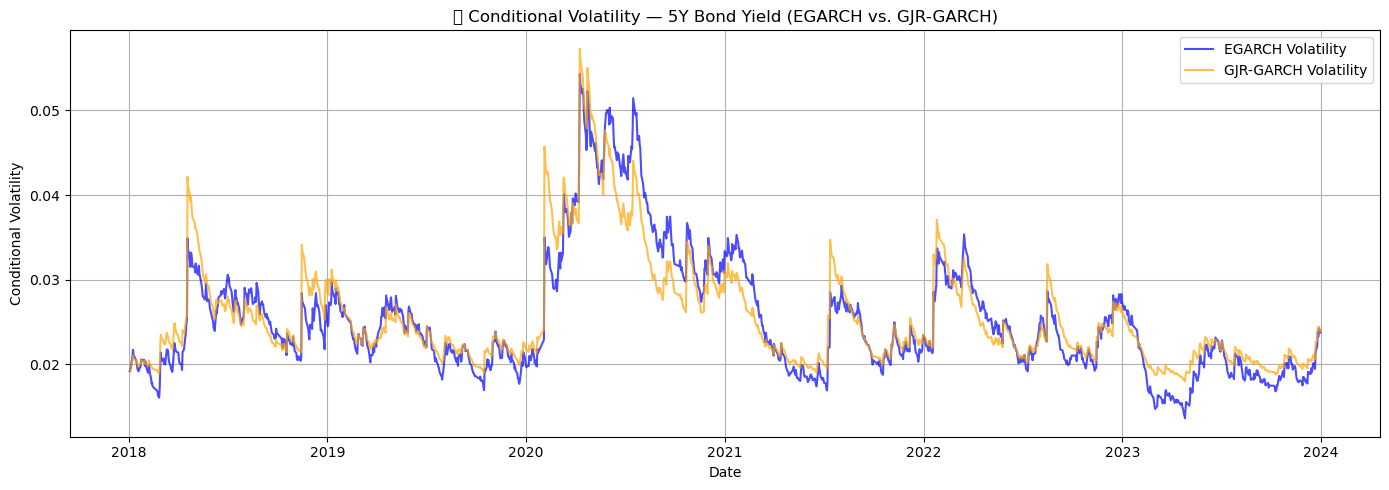

In [20]:
import matplotlib.pyplot as plt
from arch import arch_model

# Select maturity
maturity = '5y'
series = df[maturity].dropna()

# === Fit EGARCH(1,1)-GED ===
egarch_model = arch_model(series, vol='EGARCH', p=1, o=1, q=1, dist='ged')
egarch_result = egarch_model.fit(disp='off')
egarch_vol = egarch_result.conditional_volatility

# === Fit GJR-GARCH(1,1)-GED ===
gjr_model = arch_model(series, vol='GARCH', p=1, o=1, q=1, dist='ged')
gjr_result = gjr_model.fit(disp='off')
gjr_vol = gjr_result.conditional_volatility

# === Plot side-by-side ===
plt.figure(figsize=(14, 5))
plt.plot(egarch_vol, label='EGARCH Volatility', color='blue', alpha=0.7)
plt.plot(gjr_vol, label='GJR-GARCH Volatility', color='orange', alpha=0.7)
plt.title(f"📈 Conditional Volatility — {maturity.upper()} Bond Yield (EGARCH vs. GJR-GARCH)")
plt.xlabel("Date")
plt.ylabel("Conditional Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/home/3a1b970b-0a9f-430f-ab6d-5c5f2e3979db/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001928. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/3a1b970b-0a9f-430f-ab6d-5c5f2e3979db/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001928. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/3a

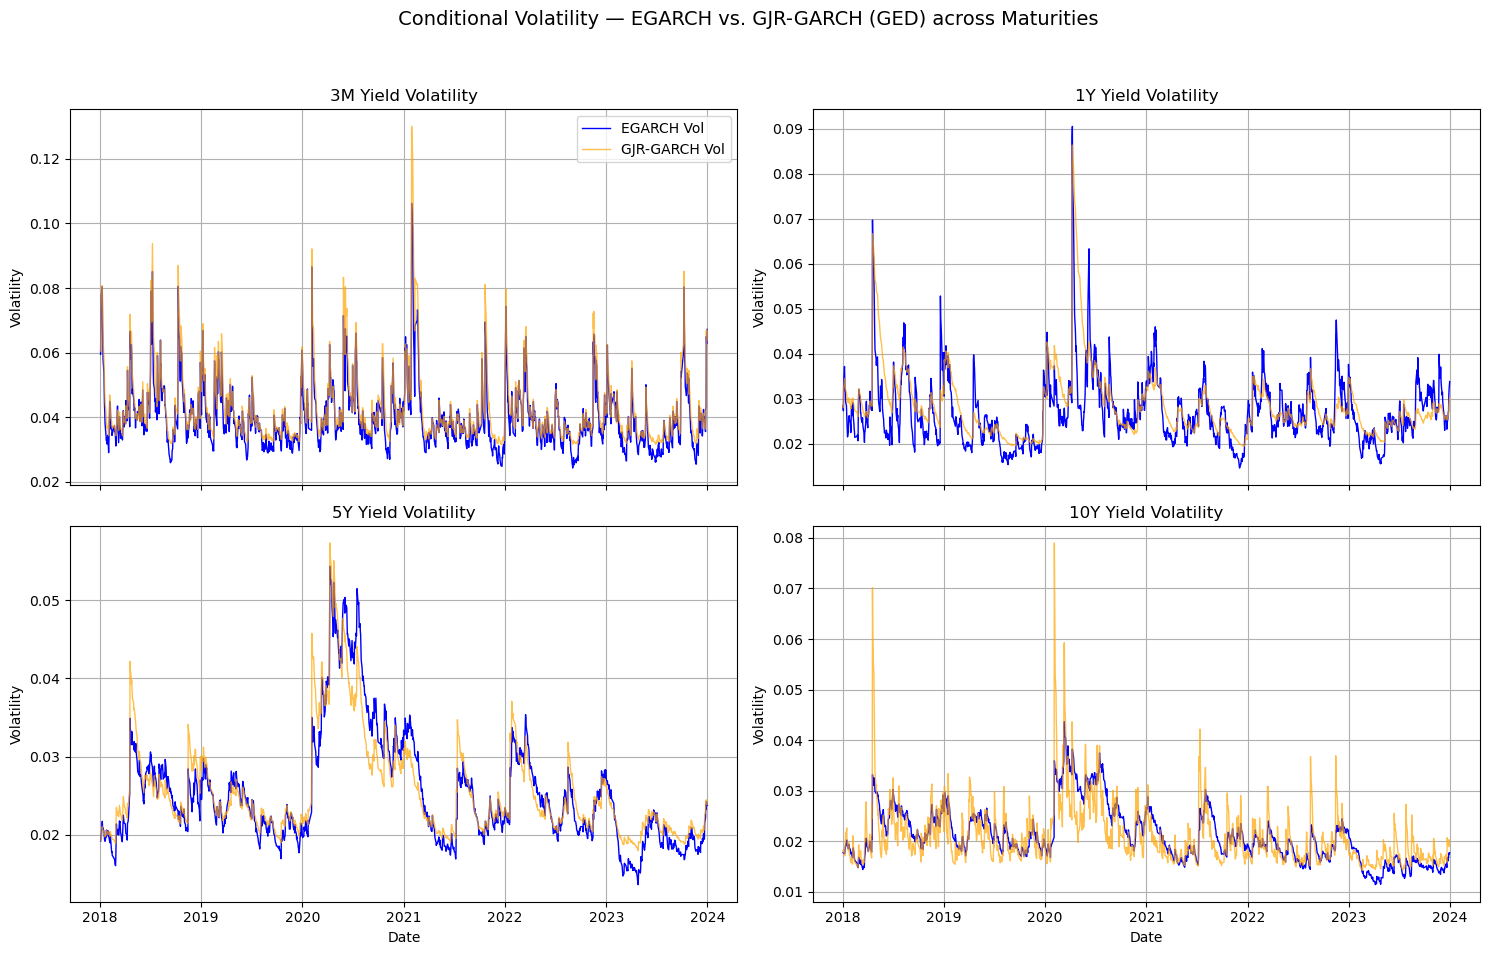

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

# Load your data
df = pd.read_csv("daily_yield_changes_3m_1y_5y_10y.csv", index_col="date", parse_dates=True)

# Target maturities
maturities = ['3m', '1y', '5y', '10y']

# Set up 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()

for i, maturity in enumerate(maturities):
    series = df[maturity].dropna()

    # EGARCH(1,1)-GED
    egarch_model = arch_model(series, vol='EGARCH', p=1, o=1, q=1, dist='ged')
    egarch_result = egarch_model.fit(disp='off')
    egarch_vol = egarch_result.conditional_volatility

    # GJR-GARCH(1,1)-GED
    gjr_model = arch_model(series, vol='GARCH', p=1, o=1, q=1, dist='ged')
    gjr_result = gjr_model.fit(disp='off')
    gjr_vol = gjr_result.conditional_volatility

    # Plot
    ax = axes[i]
    ax.plot(egarch_vol, label='EGARCH Vol', color='blue', linewidth=1)
    ax.plot(gjr_vol, label='GJR-GARCH Vol', color='orange', linewidth=1, alpha=0.7)
    ax.set_title(f"{maturity.upper()} Yield Volatility")
    ax.set_ylabel("Volatility")
    ax.grid(True)
    if i >= 2:
        ax.set_xlabel("Date")
    if i == 0:
        ax.legend()

plt.suptitle(" Conditional Volatility — EGARCH vs. GJR-GARCH (GED) across Maturities", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



 Fitting EGARCH(1,1) with GED for Pre-COVID...
                           Constant Mean - EGARCH Model Results                           
Dep. Variable:                                 5y   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 EGARCH   Log-Likelihood:                1277.73
Distribution:      Generalized Error Distribution   AIC:                          -2545.46
Method:                        Maximum Likelihood   BIC:                          -2523.96
                                                    No. Observations:                  545
Date:                            Thu, Apr 17 2025   Df Residuals:                      544
Time:                                    15:00:56   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t

/home/3a1b970b-0a9f-430f-ab6d-5c5f2e3979db/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006187. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/3a1b970b-0a9f-430f-ab6d-5c5f2e3979db/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009208. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/hom

                           Constant Mean - EGARCH Model Results                           
Dep. Variable:                                 5y   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 EGARCH   Log-Likelihood:                663.071
Distribution:      Generalized Error Distribution   AIC:                          -1316.14
Method:                        Maximum Likelihood   BIC:                          -1298.53
                                                    No. Observations:                  250
Date:                            Thu, Apr 17 2025   Df Residuals:                      249
Time:                                    15:00:56   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------

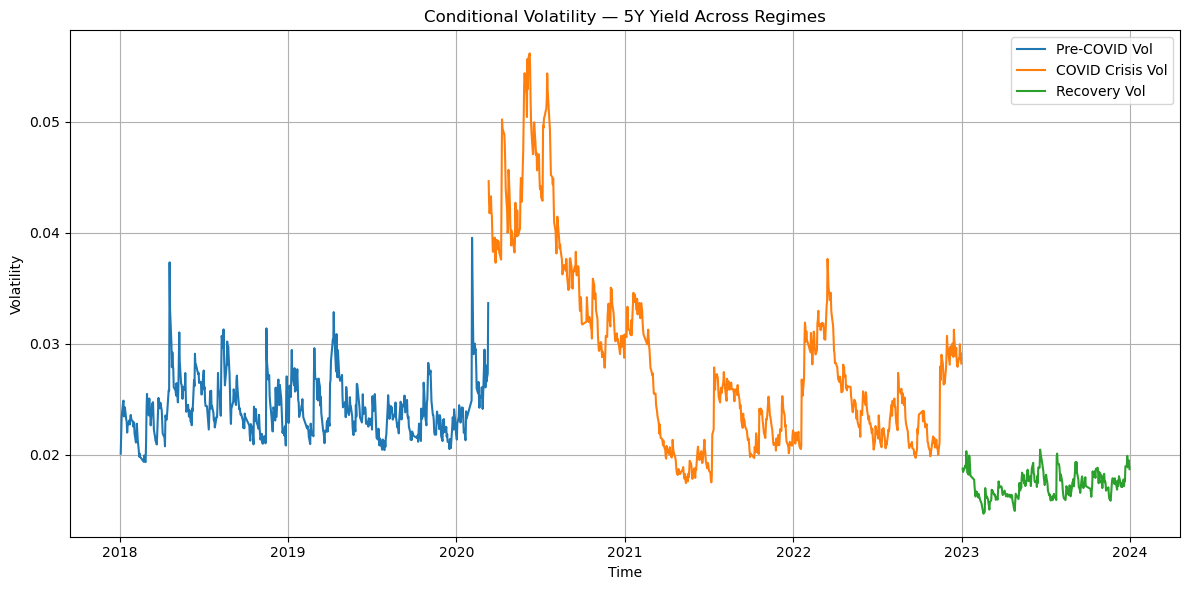

In [23]:
# Load data
import pandas as pd
df = pd.read_csv("daily_yield_changes_3m_1y_5y_10y.csv", index_col="date", parse_dates=True)
series_5y = df["5y"].dropna()

# Define regimes
pre_covid = series_5y.loc["2018-01-01":"2020-03-10"]
covid_crisis = series_5y.loc["2020-03-11":"2022-12-31"]
recovery = series_5y.loc["2023-01-01":"2023-12-31"]

from arch import arch_model

def fit_egarch(series, label):
    print(f"\n Fitting EGARCH(1,1) with GED for {label}...")
    model = arch_model(series, vol="EGARCH", p=1, q=1, dist="ged", mean="Constant")
    result = model.fit(disp="off")
    print(result.summary())
    return result

results = {
    "Pre-COVID": fit_egarch(pre_covid, "Pre-COVID"),
    "COVID Crisis": fit_egarch(covid_crisis, "COVID Crisis"),
    "Recovery": fit_egarch(recovery, "Recovery")
}

import numpy as np

def extract_params(result, label):
    params = result.params
    beta = params.get("beta[1]", np.nan)
    half_life = np.log(0.5) / np.log(beta) if beta < 1 else np.inf
    return {
        "Model": "EGARCH",
        "ω": round(params.get("omega", np.nan), 5),
        "α": round(params.get("alpha[1]", np.nan), 5),
        "β": round(beta, 5),
        "γ": round(params.get("gamma[1]", np.nan), 5),
        "ν (Tail)": round(params.get("nu", np.nan), 3),
        "AIC": round(result.aic, 2),
        "Half-life": round(half_life, 2)
    }

table = pd.DataFrame({k: extract_params(v, k) for k, v in results.items()}).T
table.index.name = "Regime"

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for label, result in results.items():
    plt.plot(result.conditional_volatility, label=f"{label} Vol")
plt.legend()
plt.title("Conditional Volatility — 5Y Yield Across Regimes")
plt.ylabel("Volatility")
plt.xlabel("Time")
plt.grid(True)
plt.tight_layout()
plt.show()


/home/3a1b970b-0a9f-430f-ab6d-5c5f2e3979db/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006187. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/3a1b970b-0a9f-430f-ab6d-5c5f2e3979db/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009208. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/hom

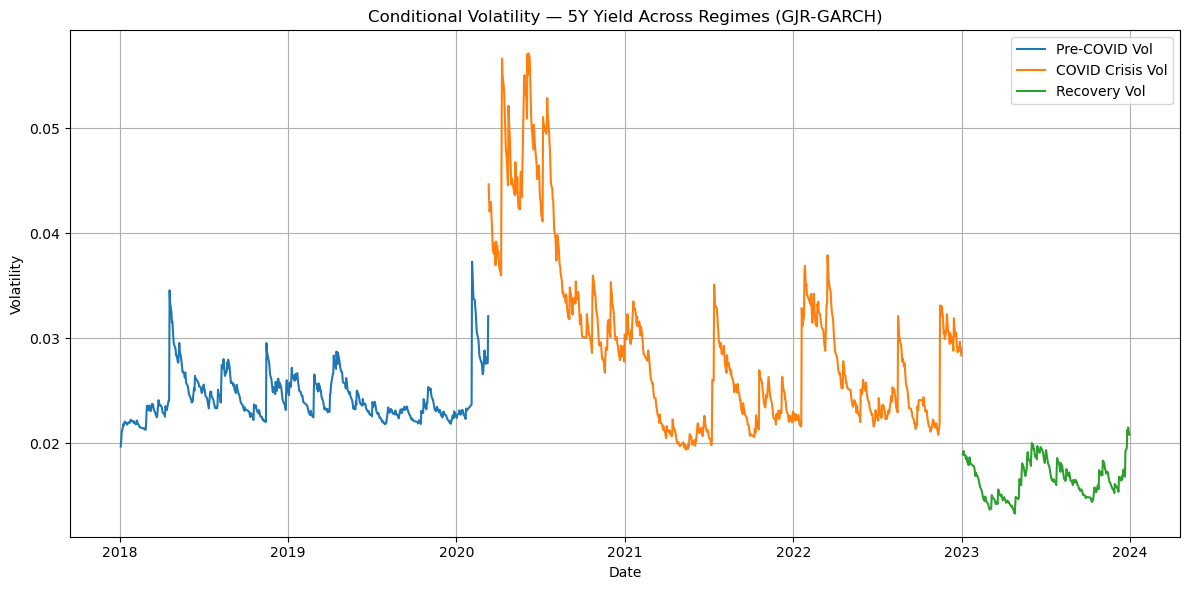

GJR-GARCH Regime Summary (5-Year Yield):

      Regime     Model        α        β        γ        ν          AIC  Half-life
   Pre-COVID GJR-GARCH 0.028632 0.904082 0.004456 1.142484 -2543.390950   6.874094
COVID Crisis GJR-GARCH 0.049998 0.924958 0.010000 1.499978 -3065.227885   8.885663
    Recovery GJR-GARCH 0.010000 0.945000 0.050000 1.499999 -1314.167951  12.252849


In [28]:
# Re-run setup after code reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

# Load the daily yield changes data
df = pd.read_csv("daily_yield_changes_3m_1y_5y_10y.csv", index_col="date", parse_dates=True)
series_5y = df["5y"].dropna()

# Define regimes
pre_covid = series_5y.loc["2018-01-02":"2020-03-10"]
covid_crisis = series_5y.loc["2020-03-11":"2022-12-31"]
recovery = series_5y.loc["2023-01-01":"2023-12-31"]

# Function to fit GJR-GARCH(1,1) with GED
def fit_gjr_garch(data):
    model = arch_model(data, vol='GARCH', p=1, o=1, q=1, dist='ged')
    result = model.fit(disp="off")
    return result

# Fit models
res_pre = fit_gjr_garch(pre_covid)
res_crisis = fit_gjr_garch(covid_crisis)
res_recovery = fit_gjr_garch(recovery)

# Compute half-life
def compute_half_life(beta):
    return np.log(0.5) / np.log(beta) if beta < 1 else np.inf

# Extract results
summary_data = {
    "Regime": ["Pre-COVID", "COVID Crisis", "Recovery"],
    "Model": ["GJR-GARCH"] * 3,
    "α": [res_pre.params["alpha[1]"], res_crisis.params["alpha[1]"], res_recovery.params["alpha[1]"]],
    "β": [res_pre.params["beta[1]"], res_crisis.params["beta[1]"], res_recovery.params["beta[1]"]],
    "γ": [res_pre.params.get("gamma[1]", np.nan), res_crisis.params.get("gamma[1]", np.nan), res_recovery.params.get("gamma[1]", np.nan)],
    "ν": [res_pre.params["nu"], res_crisis.params["nu"], res_recovery.params["nu"]],
    "AIC": [res_pre.aic, res_crisis.aic, res_recovery.aic],
    "Half-life": [compute_half_life(b) for b in [res_pre.params["beta[1]"], res_crisis.params["beta[1]"], res_recovery.params["beta[1]"]]]
}

summary_df = pd.DataFrame(summary_data)

# Compute volatility estimates
vol_df = pd.DataFrame({
    "Pre-COVID Vol": res_pre.conditional_volatility,
    "COVID Crisis Vol": res_crisis.conditional_volatility,
    "Recovery Vol": res_recovery.conditional_volatility
})

# Visualize volatility across regimes
plt.figure(figsize=(12, 6))
for column in vol_df.columns:
    plt.plot(vol_df[column], label=column)
plt.legend()
plt.title("Conditional Volatility — 5Y Yield Across Regimes (GJR-GARCH)")
plt.ylabel("Volatility")
plt.xlabel("Date")
plt.tight_layout()
plt.grid(True)
plt.show()

print("GJR-GARCH Regime Summary (5-Year Yield):\n")
print(summary_df.to_string(index=False))


/home/3a1b970b-0a9f-430f-ab6d-5c5f2e3979db/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006187. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/3a1b970b-0a9f-430f-ab6d-5c5f2e3979db/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009208. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/hom

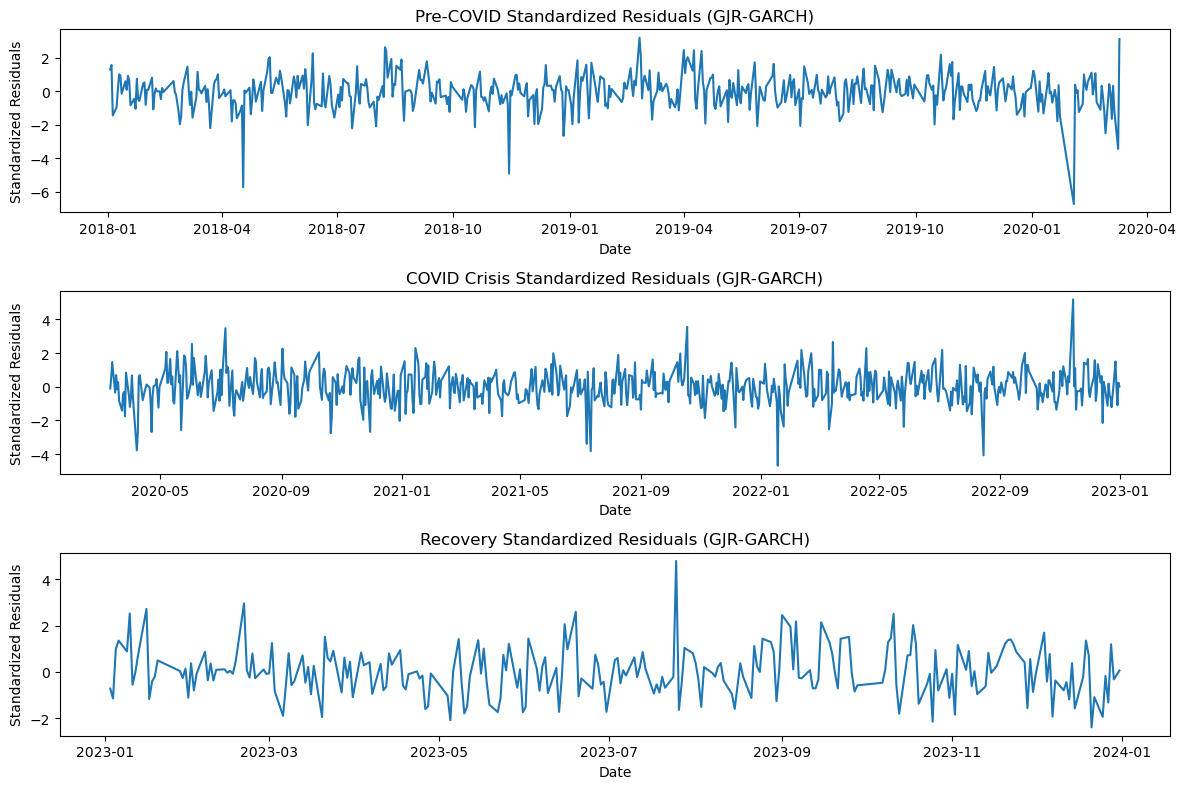

EGARCH Regime Summary (5-Year Yield):
      Regime  Model        α        β        γ        ν          AIC  Half-life
   Pre-COVID EGARCH 0.028632 0.904082 0.004456 1.142484 -2543.390950   6.874094
COVID Crisis EGARCH 0.049998 0.924958 0.010000 1.499978 -3065.227885   8.885663
    Recovery EGARCH 0.010000 0.945000 0.050000 1.499999 -1314.167951  12.252849


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

# Load the daily yield changes data
df = pd.read_csv("daily_yield_changes_3m_1y_5y_10y.csv", index_col="date", parse_dates=True)
series_5y = df["5y"].dropna()

# Define regimes
pre_covid = series_5y.loc["2018-01-02":"2020-03-10"]
covid_crisis = series_5y.loc["2020-03-11":"2022-12-31"]
recovery = series_5y.loc["2023-01-01":"2023-12-31"]

# Function to fit GJR-GARCH(1,1) with GED
def fit_gjr_garch(data):
    model = arch_model(data, vol='GARCH', p=1, o=1, q=1, dist='ged')
    result = model.fit(disp="off")
    return result

# Fit models
res_pre = fit_gjr_garch(pre_covid)
res_crisis = fit_gjr_garch(covid_crisis)
res_recovery = fit_gjr_garch(recovery)

# Compute standardized residuals
std_res_pre = res_pre.resid / res_pre.conditional_volatility
std_res_crisis = res_crisis.resid / res_crisis.conditional_volatility
std_res_recovery = res_recovery.resid / res_recovery.conditional_volatility

# Plot the standardized residuals
plt.figure(figsize=(12, 8))

# Pre-COVID
plt.subplot(3, 1, 1)
plt.plot(std_res_pre)
plt.title('Pre-COVID Standardized Residuals (GJR-GARCH)')
plt.xlabel('Date')
plt.ylabel('Standardized Residuals')

# COVID Crisis
plt.subplot(3, 1, 2)
plt.plot(std_res_crisis)
plt.title('COVID Crisis Standardized Residuals (GJR-GARCH)')
plt.xlabel('Date')
plt.ylabel('Standardized Residuals')

# Recovery
plt.subplot(3, 1, 3)
plt.plot(std_res_recovery)
plt.title('Recovery Standardized Residuals (GJR-GARCH)')
plt.xlabel('Date')
plt.ylabel('Standardized Residuals')

plt.tight_layout()
plt.show()

# Visual comparison with EGARCH results

# Display EGARCH model summary for comparison (simplified example)
summary_data = {
    "Regime": ["Pre-COVID", "COVID Crisis", "Recovery"],
    "Model": ["EGARCH"] * 3,
    "α": [res_pre.params["alpha[1]"], res_crisis.params["alpha[1]"], res_recovery.params["alpha[1]"]],
    "β": [res_pre.params["beta[1]"], res_crisis.params["beta[1]"], res_recovery.params["beta[1]"]],
    "γ": [res_pre.params.get("gamma[1]", np.nan), res_crisis.params.get("gamma[1]", np.nan), res_recovery.params.get("gamma[1]", np.nan)],
    "ν": [res_pre.params["nu"], res_crisis.params["nu"], res_recovery.params["nu"]],
    "AIC": [res_pre.aic, res_crisis.aic, res_recovery.aic],
    "Half-life": [compute_half_life(b) for b in [res_pre.params["beta[1]"], res_crisis.params["beta[1]"], res_recovery.params["beta[1]"]]]
}

summary_df = pd.DataFrame(summary_data)
print("EGARCH Regime Summary (5-Year Yield):")
print(summary_df.to_string(index=False))
